In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.utils import shuffle
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from functools import reduce
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


pd.options.display.max_columns = None

# Step 3
# Working create Spark session 
# Initialize Spark session with the spark-excel library
# Stop any existing Spark session 
# "com.crealytics:spark-excel_2.12:0.13.5" was needed as other configs did not work with the version of Excel the files were supplied with.

fileNameCSV = "WA_Fn-UseC_-HR-Employee-Attrition.csv"
sheet_name = 'WA_Fn-UseC_-HR-Employee-Attriti'
#df = pd.read_excel(fileName, header=0, sheet_name=sheet_name)
try:
    # Attempt to read the CSV file into a DataFrame
    df = pd.read_csv(fileNameCSV)
    print(df.head())
except PermissionError:
    print(f"PermissionError: You do not have permission to read the file '{fileNameCSV}'.")
except FileNotFoundError:
    print(f"FileNotFoundError: The file '{fileNameCSV}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")



   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  

In [92]:
#check for data quality
# Check for missing values in the entire dataset
print("Check for missing values (True indicates missing):")
print(df.isna())

# Check for missing values per column
print("\nCount of missing values per column:")
print(df.isna().sum())

# Check if there are missing values anywhere in the dataset
print("\nAre there any missing values in the dataset?")
print(df.isna().any().any())

# Display the data types of each column
print("Data types of the dataset:")
print(df.dtypes)

Check for missing values (True indicates missing):
        Age  Attrition  BusinessTravel  DailyRate  Department  \
0     False      False           False      False       False   
1     False      False           False      False       False   
2     False      False           False      False       False   
3     False      False           False      False       False   
4     False      False           False      False       False   
...     ...        ...             ...        ...         ...   
1465  False      False           False      False       False   
1466  False      False           False      False       False   
1467  False      False           False      False       False   
1468  False      False           False      False       False   
1469  False      False           False      False       False   

      DistanceFromHome  Education  EducationField  EmployeeCount  \
0                False      False           False          False   
1                False      Fals

In [93]:
#Now convert the text value in file to a number so statics can be generated and save to a excel format
# Sample DataFrame
# Define the mapping dictionary
# Convert text labels to numerical values for the 'Attrition' column
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['BusinessTravel'] = df['BusinessTravel'].map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
df['Department'] = df['Department'].map({ 'Sales': 0, 'Research & Development': 1, 'Human Resources': 2})
df['EducationField'] = df['EducationField'].map({ 'Life Sciences': 0, 'Other': 1, 'Human Resources': 2, 'Marketing': 3, 'Medical': 4, 'Technical Degree': 5})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['JobRole'] = df['JobRole'].map({ 'Healthcare Representative': 0, 'Human Resources': 1, 'Laboratory Technician': 2, 'Manager': 3, 'Manufacturing Director': 4, 'Research Director': 5, 'Research Scientist': 6, 'Sales Executive': 7, 'Sales Representative': 8})
df['MaritalStatus'] = df['MaritalStatus'].map({'Single': 0, 'Married': 1, 'Divorced': 2})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df['Over18'] = df['Over18'].map({'Y': 1, 'N': 0})

# Check for any missing values after mapping
print(df.isnull().sum())
# Handle any missing values
df = df.dropna()
# Check data quality

# Verify that all features are numeric
print(df.dtypes)

# Save the DataFrame as a CSV file
df.to_csv("WholeDataAsNumbers.csv", index=False)
# Select Attrition, BusinessTravel, JobSatisfaction,  and WorkLifeBalance columns
selectedDF = df.iloc[:, [1, 2, 16, 29]]
selectedDF.to_csv("SelectedDataAsNumbers.csv", index=False)

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [94]:



#-------------------------------------------
#Below we are doing a correlation matrix to see which features are most correlated with the target variable
# Calculate the correlation matrix same as what we did in lab 5
corr_matrix = df.corr()

# Select features with high correlation to the target
corr_target = corr_matrix['Attrition'].abs().sort_values(ascending=False)
print(corr_target)

# Define features and target
X = df.drop(['Attrition'], axis=1)
y = df['Attrition']
#-------------------------------------------
# Below we are doing a Multiple Linear Regression
# Define the independent variables (features)
feauresDF = df[['BusinessTravel', 'JobSatisfaction', 'WorkLifeBalance']]

# Add a constant (intercept) to the model
feaures = sm.add_constant(feauresDF)

# Define the dependent variable (target)
target = df['Attrition']

# Fit the Multiple Linear Regression model
model = sm.OLS(target, feauresDF).fit()

# Display the model summary
print(model.summary())



Attrition                   1.000000
OverTime                    0.246118
TotalWorkingYears           0.171063
JobLevel                    0.169105
MaritalStatus               0.162070
YearsInCurrentRole          0.160545
MonthlyIncome               0.159840
Age                         0.159205
YearsWithCurrManager        0.156199
StockOptionLevel            0.137145
YearsAtCompany              0.134392
JobInvolvement              0.130016
BusinessTravel              0.127006
JobSatisfaction             0.103481
EnvironmentSatisfaction     0.103369
DistanceFromHome            0.077924
JobRole                     0.067151
Department                  0.063991
WorkLifeBalance             0.063939
TrainingTimesLastYear       0.059478
DailyRate                   0.056652
RelationshipSatisfaction    0.045872
NumCompaniesWorked          0.043494
EducationField              0.035303
YearsSinceLastPromotion     0.033019
Education                   0.031373
Gender                      0.029453
M

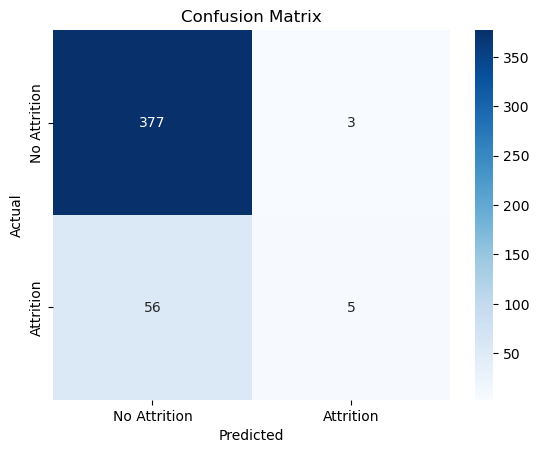

In [95]:


#-------------------------------------------
#Below we are doign a confusion matrix to see how well the model is doing
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attrition', 'Attrition'], yticklabels=['No Attrition', 'Attrition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


OverTime         0   1
BusinessTravel        
0                5   7
1               72  84
2               33  36


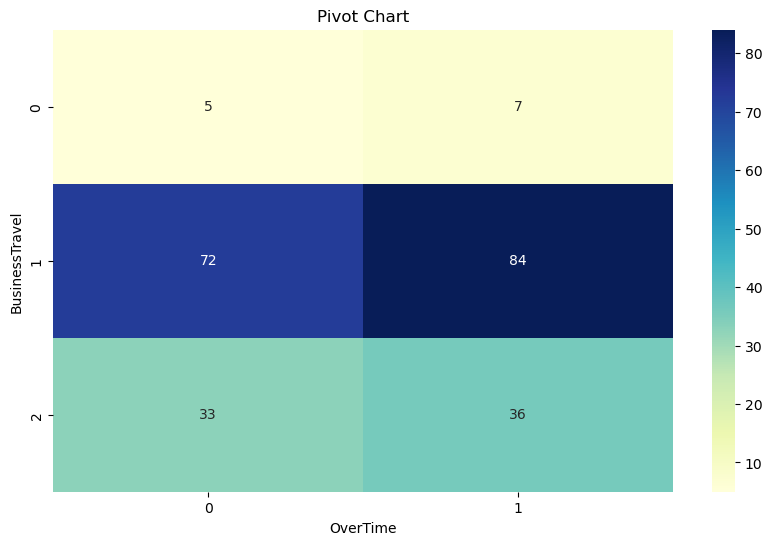

BusinessTravel    0    1    2
Attrition                    
0               138  887  208
1                12  156   69


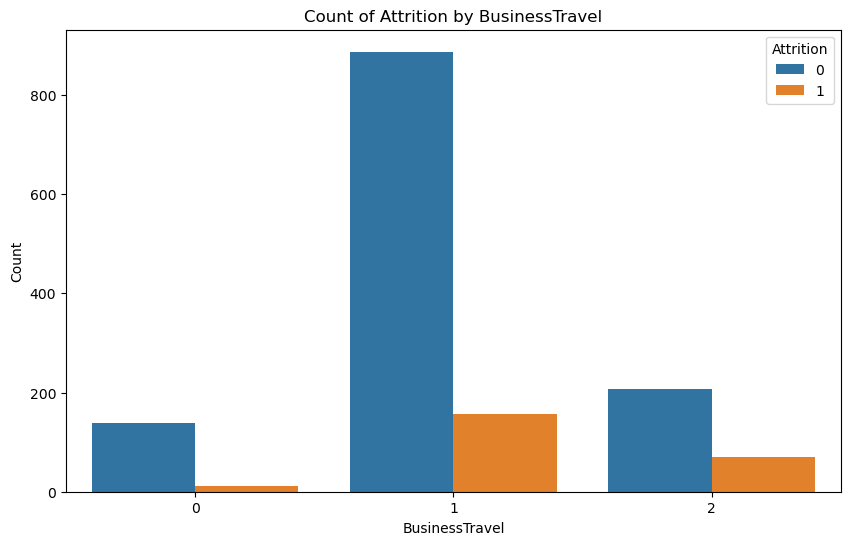

Attrition         0    1  Percentage_Attrition
BusinessTravel                                
0               138   12              8.000000
1               887  156             14.956855
2               208   69             24.909747


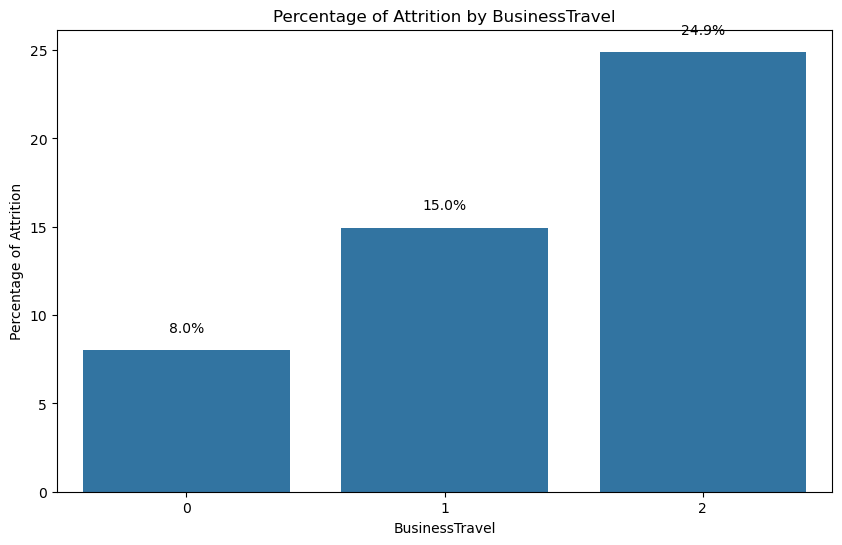

In [96]:
pivot_table = df.pivot_table(values='Attrition', index='BusinessTravel', columns='OverTime', aggfunc='sum')
print(pivot_table)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Pivot Chart')
plt.show()

# Create a pivot table with count of Attrition as values
pivot_table = pd.pivot_table(df, index='Attrition', columns='BusinessTravel', values='JobSatisfaction', aggfunc='count', fill_value=0)

# Display the pivot table
print(pivot_table)

# Reset the pivot table index to use it for plotting
pivot_table = pivot_table.reset_index()

# Melt the pivot table to long format for seaborn
pivot_table_melted = pivot_table.melt(id_vars='Attrition', var_name='BusinessTravel', value_name='Count')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table_melted, x='BusinessTravel', y='Count', hue='Attrition')
plt.title('Count of Attrition by BusinessTravel')
plt.xlabel('BusinessTravel')
plt.ylabel('Count')
plt.show()

# Group by BusinessTravel and Attrition, and count occurrences
grouped = df.groupby(['BusinessTravel', 'Attrition']).size().unstack(fill_value=0)

# Calculate the percentage of attrition for each BusinessTravel category
grouped['Percentage_Attrition'] = grouped[1] / (grouped[1] + grouped[0]) * 100

# Display the result
print(grouped)


# Group by BusinessTravel and Attrition, and count occurrences
grouped = df.groupby(['BusinessTravel', 'Attrition']).size().unstack(fill_value=0)

# Calculate the percentage of attrition for each BusinessTravel category
grouped['Percentage_Attrition'] = grouped[1] / (grouped[1] + grouped[0]) * 100

# Reset the index to use it for plotting
grouped = grouped.reset_index()

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='BusinessTravel', y='Percentage_Attrition')
plt.title('Percentage of Attrition by BusinessTravel')
plt.xlabel('BusinessTravel')
plt.ylabel('Percentage of Attrition')

# Display values on the bars
for index, row in grouped.iterrows():
    plt.text(index, row['Percentage_Attrition'] + 1, f"{row['Percentage_Attrition']:.1f}%", color='black', ha="center")

plt.show()

Selected Features: Index(['Age', 'JobLevel', 'MaritalStatus', 'MonthlyIncome', 'OverTime',
       'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsWithCurrManager'],
      dtype='object')
Accuracy: 0.8616780045351474
Confusion Matrix:
 [[371   9]
 [ 52   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.92       380
           1       0.50      0.15      0.23        61

    accuracy                           0.86       441
   macro avg       0.69      0.56      0.58       441
weighted avg       0.82      0.86      0.83       441



/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7 20 25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


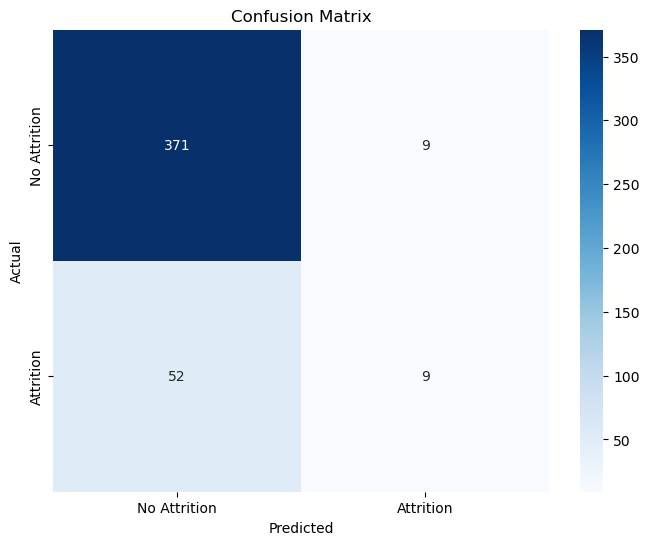

In [97]:
#Gary messing about

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset (replace 'your_dataset.csv' with the actual path to your file)
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Encode categorical variables
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Define features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

from sklearn.feature_selection import SelectKBest, f_classif

# Select the top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Attrition', 'Attrition'], yticklabels=['No Attrition', 'Attrition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Load your dataset (replace 'your_dataset.csv' with the actual path to your file)
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Encode categorical variables
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Define features and target
df.drop('StandardHours', axis=1)
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Feature selection (optional): For simplicity, we'll use all features here
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

def predict_attrition(model, user_input, X_train):
    # Convert user input into a DataFrame
    input_df = pd.DataFrame([user_input], columns=X_train.columns)
    
    # Check for NaN values and replace them with the mean/mode of the training data
    for column in input_df.columns:
        if input_df[column].isna().any():
            if input_df[column].dtype == 'object' or input_df[column].nunique() < 10:  # Categorical
                input_df[column].fillna(X_train[column].mode()[0], inplace=True)
            else:  # Numerical
                input_df[column].fillna(X_train[column].mean(), inplace=True)
    
    # Predict the probability of attrition
    attrition_prob = model.predict_proba(input_df)[0][1]
    
    # Predict attrition (0: No, 1: Yes)
    attrition_pred = model.predict(input_df)[0]
    
    return attrition_pred, attrition_prob

# Example user input (replace with actual user input)
user_input = {
    'Age': 35,
    'BusinessTravel': 1, # Assuming 1 for Travel_Rarely
    'DailyRate': 110,
    'Department': 1, # Assuming 1 for Research & Development
    'DistanceFromHome': 50,
    'Education': 3,
    'EducationField': 2, # Assuming 2 for Other
    'EnvironmentSatisfaction': 4,
    'Gender': 1, # Assuming 1 for Male
    'HourlyRate': 60,
    'JobInvolvement': 1,
    'JobLevel': 2,
    'JobRole': 1, # Assuming 4 for Manufacturing Director
    'JobSatisfaction': 4,
    'MaritalStatus': 3, # Assuming 3 for Divorced
    'MonthlyIncome': 700,
    'MonthlyRate': 1400,
    'NumCompaniesWorked': 9,
    'OverTime': 1, # Assuming 1 for Yes
    'PercentSalaryHike': 5,
    'PerformanceRating': 1,
    'RelationshipSatisfaction': 1,
    #'StandardHours': 80,
    'StockOptionLevel': 1,
    'TotalWorkingYears': 20,
    'TrainingTimesLastYear': 0,
    'WorkLifeBalance': 1,
    'YearsAtCompany': 1,
    'YearsInCurrentRole': 1,
    'YearsSinceLastPromotion': 0,
    'YearsWithCurrManager': 1
}

# Predict attrition using the user input
attrition_pred, attrition_prob = predict_attrition(model, user_input, X_train)

# Display the prediction result
print(f"Predicted Attrition: {'Yes' if attrition_pred == 1 else 'No'}")
print(f"Probability of Attrition: {attrition_prob:.2f}")

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(200, 100))
tree.plot_tree(dt_model, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.title('Decision Tree for Attrition Prediction')
plt.show()



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/bl/mrjmtt695nq8nz36p_fp8b0r0000gn/T/ipykernel_52231/3099572501.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=

Predicted Attrition: Yes
Probability of Attrition: 0.55


/var/folders/bl/mrjmtt695nq8nz36p_fp8b0r0000gn/T/ipykernel_52231/571317929.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Attrition", loc="upper right")


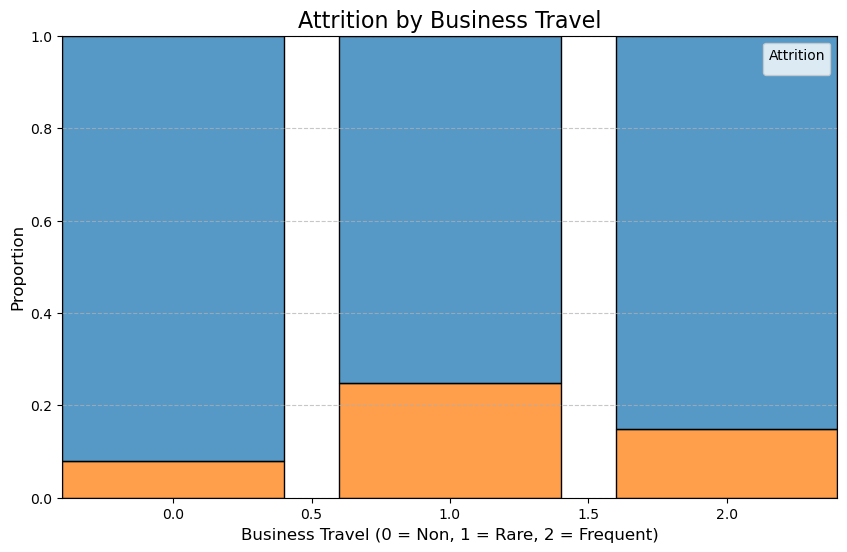

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `WholeDataAsNumbers` is your DataFrame
# Example DataFrame (replace this with your actual data)
data = {
    'BusinessTravel': [0, 1, 2, 0, 1, 2, 1, 0, 2, 1],
    'Attrition': [1, 0, 1, 0, 1, 0, 1, 1, 0, 0]
}
WholeDataAsNumbers = df#pd.DataFrame(data)

# Convert 'BusinessTravel' and 'Attrition' to categorical variables
WholeDataAsNumbers['BusinessTravel'] = WholeDataAsNumbers['BusinessTravel'].astype('category')
WholeDataAsNumbers['Attrition'] = WholeDataAsNumbers['Attrition'].astype('category')

# Create a proportion bar plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=WholeDataAsNumbers,
    x="BusinessTravel",
    hue="Attrition",
    multiple="fill",  # This sets the bars to proportions
    stat="probability",
    shrink=0.8
)

# Add labels and title
plt.title("Attrition by Business Travel", fontsize=16)
plt.xlabel("Business Travel (0 = Non, 1 = Rare, 2 = Frequent)", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.legend(title="Attrition", loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




/var/folders/bl/mrjmtt695nq8nz36p_fp8b0r0000gn/T/ipykernel_52231/3982943589.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


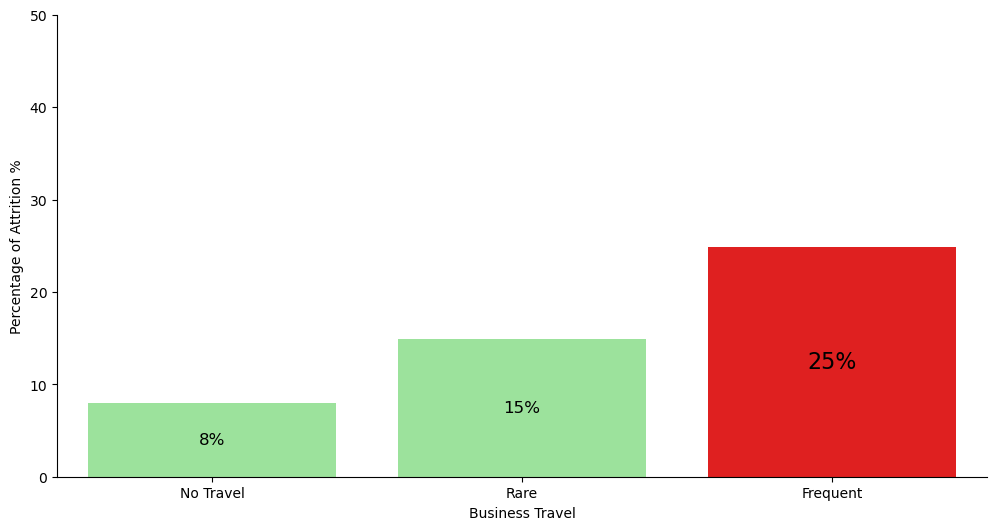

In [100]:



# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped, 
    x='BusinessTravel', 
    y='Percentage_Attrition', 
    palette=["lightgreen", "lightgreen", "red"]  # Set specific colors for bars
)
#plt.title('Percentage of Attrition by Business Travel')
plt.xlabel('Business Travel')
plt.ylabel('Percentage of Attrition %')
# Change x-axis tick labels
plt.xticks(ticks=range(len(grouped['BusinessTravel'])), labels=['No Travel', 'Rare', 'Frequent'])
# Remove the top and right borders
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)   # Hide the top spine
ax.spines['right'].set_visible(False) # Hide the right spine
# Set y-axis limit
plt.ylim(0, 50)

# Display values within the bars
for index, row in grouped.iterrows():
    font_size = 16 if index == 2 else 12  # Apply larger font size for the third column
    plt.text(
        index,                      # X-coordinate (bar position)
        row['Percentage_Attrition'] / 2,  # Y-coordinate (center of the bar)
        f"{row['Percentage_Attrition']:.0f}%",  # Text (e.g., percentage value)
        color='black',              # Text color for visibility
        ha="center",                # Horizontal alignment
        va="center",                # Vertical alignment
        fontsize=font_size          # Set font size dynamically
    )



   Age  Attrition  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0   41          1               1       1102           0                 1   
1   49          0               2        279           1                 8   
2   37          1               1       1373           1                 2   
3   33          0               2       1392           1                 3   
4   27          0               1        591           1                 2   

   Education  EducationField  EmployeeCount  EmployeeNumber  \
0          2               0              1               1   
1          1               0              1               2   
2          2               1              1               4   
3          4               0              1               5   
4          1               4              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
0                        2       0          94               3         2   


/var/folders/bl/mrjmtt695nq8nz36p_fp8b0r0000gn/T/ipykernel_52231/2758198180.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bl/mrjmtt695nq8nz36p_fp8b0r0000gn/T/ipykernel_52231/2758198180.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


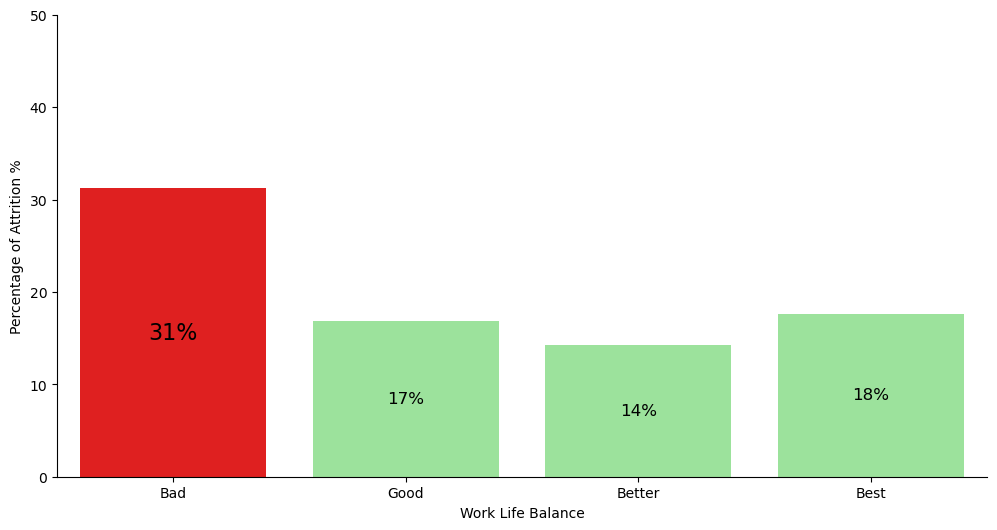

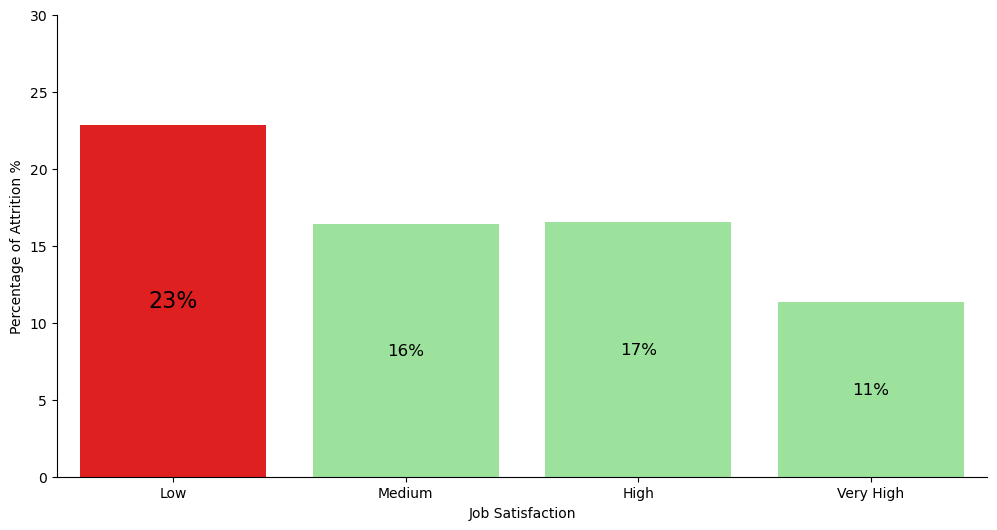

In [105]:
fileNameCSV = "WholeDataAsNumbers.csv"
sheet_name = 'WA_Fn-UseC_-HR-Employee-Attriti'
#df = pd.read_excel(fileName, header=0, sheet_name=sheet_name)
try:
    # Attempt to read the CSV file into a DataFrame
    df = pd.read_csv(fileNameCSV)
    print(df.head())
except PermissionError:
    print(f"PermissionError: You do not have permission to read the file '{fileNameCSV}'.")
except FileNotFoundError:
    print(f"FileNotFoundError: The file '{fileNameCSV}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")



# Group by WorkLifeBalance and Attrition, and count occurrences
grouped = df.groupby(['WorkLifeBalance', 'Attrition']).size().unstack(fill_value=0)

# Calculate the percentage of attrition for each WorkLifeBalance category
grouped['Percentage_Attrition'] = grouped[1] / (grouped[1] + grouped[0]) * 100

# Reset the index to use it for plotting
grouped = grouped.reset_index()

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped, 
    x='WorkLifeBalance', 
    y='Percentage_Attrition', 
    palette=["red", "lightgreen", "lightgreen", "lightgreen"]  # Set specific colors for bars
)
#plt.title('Percentage of Attrition by Business Travel')
plt.xlabel('Work Life Balance')
plt.ylabel('Percentage of Attrition %')
# Change x-axis tick labels
plt.xticks(ticks=range(len(grouped['WorkLifeBalance'])), labels=['Bad', 'Good', 'Better', 'Best'])
# Remove the top and right borders
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)   # Hide the top spine
ax.spines['right'].set_visible(False) # Hide the right spine
# Set y-axis limit
plt.ylim(0, 50)

# Display values within the bars
for index, row in grouped.iterrows():
    font_size = 16 if index == 0 else 12  # Apply larger font size for the third column
    plt.text(
        index,                      # X-coordinate (bar position)
        row['Percentage_Attrition'] / 2,  # Y-coordinate (center of the bar)
        f"{row['Percentage_Attrition']:.0f}%",  # Text (e.g., percentage value)
        color='black',              # Text color for visibility
        ha="center",                # Horizontal alignment
        va="center",                # Vertical alignment
        fontsize=font_size          # Set font size dynamically
    )





# Group by JobSatisfaction and Attrition, and count occurrences
grouped = df.groupby(['JobSatisfaction', 'Attrition']).size().unstack(fill_value=0)

# Calculate the percentage of attrition for each JobSatisfaction category
grouped['Percentage_Attrition'] = grouped[1] / (grouped[1] + grouped[0]) * 100

# Reset the index to use it for plotting
grouped = grouped.reset_index()

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped, 
    x='JobSatisfaction', 
    y='Percentage_Attrition', 
    palette=["red", "lightgreen", "lightgreen", "lightgreen"]  # Set specific colors for bars
)
#plt.title('Percentage of Attrition by Business Travel')
plt.xlabel('Job Satisfaction')
plt.ylabel('Percentage of Attrition %')
# Change x-axis tick labels
plt.xticks(ticks=range(len(grouped['JobSatisfaction'])), labels=['Low', 'Medium', 'High', 'Very High'])
# Remove the top and right borders
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)   # Hide the top spine
ax.spines['right'].set_visible(False) # Hide the right spine
# Set y-axis limit
plt.ylim(0, 30)

# Display values within the bars
for index, row in grouped.iterrows():
    font_size = 16 if index == 0 else 12  # Apply larger font size for the third column
    plt.text(
        index,                      # X-coordinate (bar position)
        row['Percentage_Attrition'] / 2,  # Y-coordinate (center of the bar)
        f"{row['Percentage_Attrition']:.0f}%",  # Text (e.g., percentage value)
        color='black',              # Text color for visibility
        ha="center",                # Horizontal alignment
        va="center",                # Vertical alignment
        fontsize=font_size          # Set font size dynamically
    )
